In [1]:
from uncertainty_rnn import dataset, Current
# 데이터 불러오기
df = dataset()
# 클래스로 model 생성
current = Current(df)

In [50]:
# 데이터 읽어들이기
import json
import pandas as pd
import numpy as np

with open('Combined_LabelledData_52_역률평균.json', 'rt', encoding='UTF8') as data_file:
    data= json.load(data_file)
df = pd.DataFrame(data['data'])
df=df.set_index(['TIMESTAMP'])

# 상관관계가 가장 높은 4개를 선정해서 input data로 선정 
coef = {}
for i in df['ITEM_NAME'].unique():
    value = np.corrcoef(df[df['ITEM_NAME']=='역률평균']['ITEM_VALUE'], df[df['ITEM_NAME']==i]['ITEM_VALUE'])[0,1]
    coef[i] = value

cor_df = pd.DataFrame(list(coef.items()), columns=['ITEM', 'corr'])
features = cor_df[cor_df['corr'] > 0.9].sort_values(by=['corr'], ascending=False)['ITEM'].unique()
features = features[:4]

# 선정한 features들을 딥러닝 모델에 넣기 위한 데이터 프레임으로 생성
idx = df.index.unique()
ds = pd.DataFrame(index = idx, columns=features)
for i in features:
    ds[i] = df[df['ITEM_NAME']==i][['ITEM_VALUE']].values

In [51]:
ds = ds.join(df['LABEL_NAME'])

In [54]:
ds['LABEL_NAME'] = ds['LABEL_NAME'].map({'정상':0, '비정상':1})

In [55]:
# 1시간 별로 평균을 구해줘서 1시간 간격 데이터 생성
#ds[label] = ds[label]/3
ds.index = pd.to_datetime(ds.index)
ds = ds.groupby(pd.Grouper(freq='1H')).mean()
ds = ds.astype(np.float32)

In [60]:
ds.head()

,역률평균,R상역률,S상역률,T상역률,LABEL_NAME
TIMESTAMP,,,,,
2020-10-24 00:00:00,0.947231,0.940104,0.943229,0.952083,0.0
2020-10-24 01:00:00,0.949065,0.942123,0.945378,0.953972,0.0
2020-10-24 02:00:00,0.949365,0.942643,0.945899,0.953906,0.0
2020-10-24 03:00:00,0.948240,0.941602,0.944466,0.953060,0.0
2020-10-24 04:00:00,0.949677,0.942578,0.946094,0.954492,0.0


In [64]:
np.square(ds['역률평균'].values - ds['역률평균'].values.mean())

array([3.47500031e-06, 9.16827503e-10, 7.29692715e-08, 7.31583668e-07,
       3.38353630e-07, 1.33448157e-06, 4.81907456e-08, 8.31694342e-06,
       7.51786911e-06, 2.25252697e-05, 5.56213417e-05, 9.85140650e-05,
       1.23955964e-04, 1.62975521e-05, 5.12708357e-05, 7.56466761e-05,
       5.79124498e-05, 2.73523765e-05, 3.70444536e-06, 5.22233137e-08,
       1.15555997e-06, 1.94166773e-06, 4.25931512e-06, 3.04505079e-07,
       8.60333671e-08, 4.64533514e-08, 9.74273462e-09, 3.86421704e-08,
       4.84527938e-08, 1.12742064e-05, 1.06806256e-05, 4.30470391e-06,
       1.58858275e-05, 5.10755526e-05, 1.14704118e-04, 1.71052117e-04,
       5.05792195e-05, 6.72241949e-05, 5.81303793e-05, 5.86459500e-05,
       7.13063564e-05, 8.89427247e-05, 1.70233019e-04, 1.29936539e-04,
       1.44013466e-04, 7.71931445e-05, 3.66969289e-05, 1.54671816e-05,
       5.47540867e-06, 1.00251918e-05, 3.00248030e-06, 1.13197450e-06,
       1.60125387e-06, 1.29952241e-07, 5.62954995e-07, 4.18216963e-08,
      

In [80]:
train_loss = ds['역률평균'].values
upper = np.mean(train_loss) + 3 * np.std(train_loss)
lower = np.mean(train_loss) - 3 * np.std(train_loss)

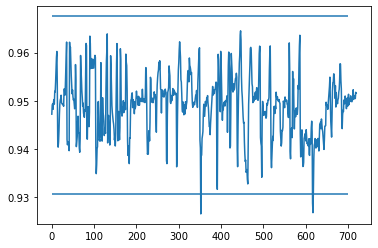

In [83]:
import matplotlib.pyplot as plt
plt.plot(ds['역률평균'].values)
plt.hlines(upper,0,700)
plt.hlines(lower,0,700)

In [88]:
train_loss_ewm = pd.DataFrame(train_loss).ewm(alpha= 0.5).mean()
ewm_upper = np.mean(train_loss_ewm) + 3 * np.std(train_loss_ewm)
ewm_lower = np.mean(train_loss_ewm) - 3 * np.std(train_loss_ewm)

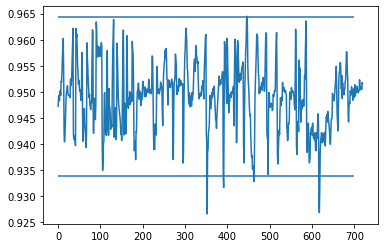

In [89]:
plt.plot(ds['역률평균'].values)
plt.hlines(ewm_upper,0,700)
plt.hlines(ewm_lower,0,700)

Epoch 1/150
2/2 [==============================] - 4s 1s/step - loss: 0.1356 - val_loss: 0.0392
Epoch 2/150
2/2 [==============================] - 1s 511ms/step - loss: 0.0291 - val_loss: -0.0528
Epoch 3/150
2/2 [==============================] - 1s 537ms/step - loss: -0.0776 - val_loss: -0.1365
Epoch 4/150
2/2 [==============================] - 1s 557ms/step - loss: -0.1825 - val_loss: -0.2198
Epoch 5/150
2/2 [==============================] - 1s 471ms/step - loss: -0.2660 - val_loss: -0.3203
Epoch 6/150
2/2 [==============================] - 1s 441ms/step - loss: -0.3771 - val_loss: -0.4982
Epoch 7/150
2/2 [==============================] - 1s 465ms/step - loss: -0.5835 - val_loss: -0.6801
Epoch 8/150
2/2 [==============================] - 1s 465ms/step - loss: -0.8227 - val_loss: -0.4950
Epoch 9/150
2/2 [==============================] - 1s 508ms/step - loss: -0.0545 - val_loss: -0.8061
Epoch 10/150
2/2 [==============================] - 1s 475ms/step - loss: -0.8830 - val_loss: -0.

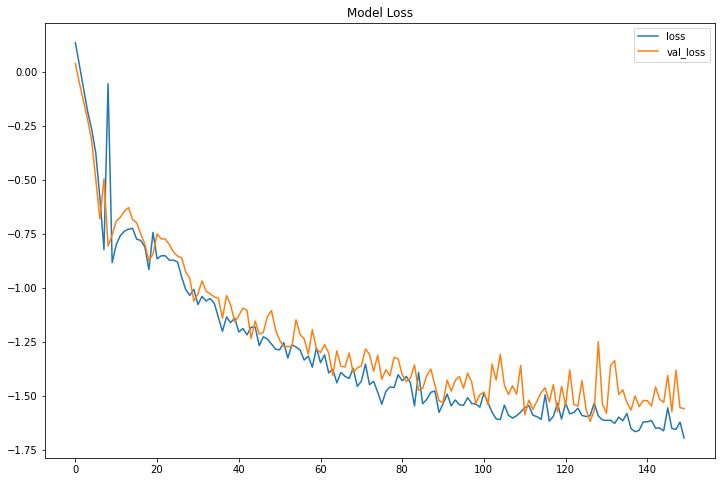

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]

rmse: 0.07549126446247101
r2: 0.3288005019892173
For LSTM uncertainty model, 0.9741935483870968 are in 99% confidence interval



c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_predict['predict'] = y_mean_transfrom
c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_predict['predict_low'] = lower_transfrom
c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

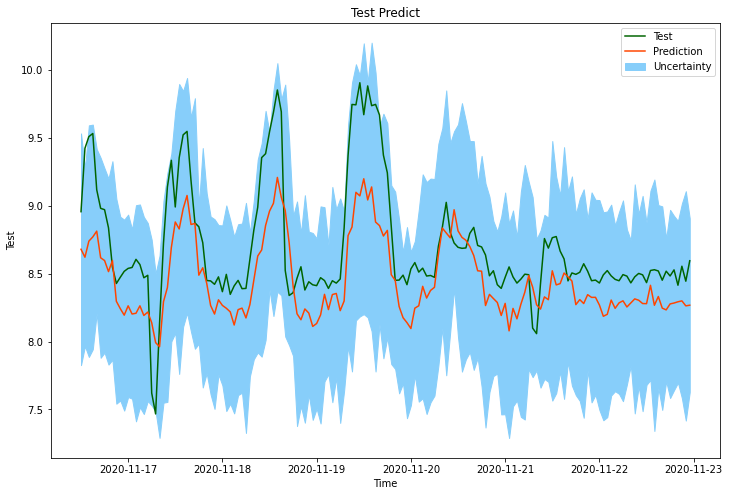

In [2]:
model1 = current.LSTM()
model1 = current.fit(model=model1, epochs = 150, batch_size = 256, show_loss = True)
LSTM_predict = current.predict_ci(model=model1, n_sample = 20, ci=2.58, show= True)

Epoch 1/150
2/2 [==============================] - 5s 1s/step - loss: 0.7669 - val_loss: 0.8557
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 0.8919 - val_loss: 0.4912
Epoch 3/150
2/2 [==============================] - 0s 79ms/step - loss: 0.4922 - val_loss: 0.2807
Epoch 4/150
2/2 [==============================] - 0s 77ms/step - loss: 0.2320 - val_loss: -0.1049
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 0.0335 - val_loss: 0.0645
Epoch 6/150
2/2 [==============================] - 0s 90ms/step - loss: -0.0821 - val_loss: 0.0399
Epoch 7/150
2/2 [==============================] - 0s 78ms/step - loss: -0.1031 - val_loss: -0.1340
Epoch 8/150
2/2 [==============================] - 0s 78ms/step - loss: -0.1326 - val_loss: -0.1858
Epoch 9/150
2/2 [==============================] - 0s 78ms/step - loss: -0.2105 - val_loss: -0.4234
Epoch 10/150
2/2 [==============================] - 0s 78ms/step - loss: -0.3590 - val_loss: -0.3222
Epoch 11/15

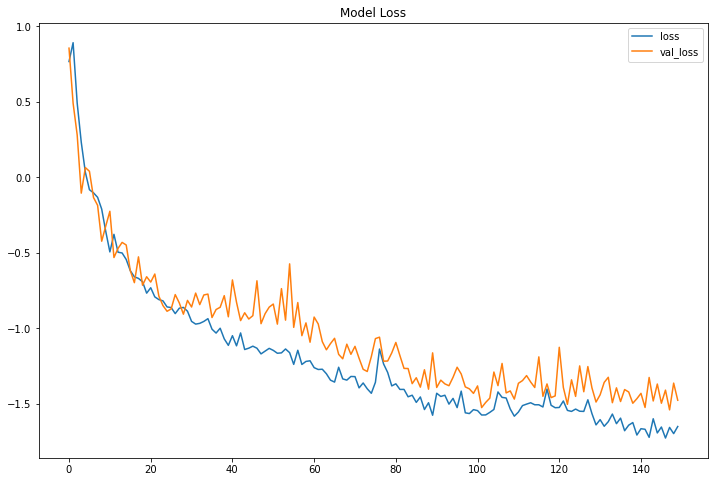

100%|██████████| 20/20 [00:01<00:00, 16.44it/s]
c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_predict['predict'] = y_mean_transfrom
c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_predict['predict_low'] = lower_transfrom
c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


rmse: 0.1101362556219101
r2: -0.4286271294467161
For LSTM uncertainty model, 0.7483870967741936 are in 99% confidence interval


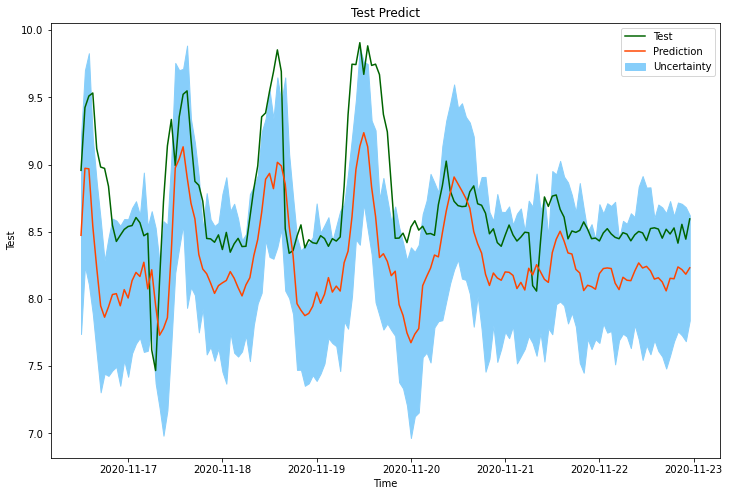

In [3]:
model2 = current.Transfomer_Conv(key_dim = 128, num_heads=2, ff_dim=128, num_blocks=1)
model2 = current.fit(model=model2, epochs = 150, batch_size = 256, show_loss = True)
TransformerConv_predict = current.predict_ci(model=model2, n_sample = 20, ci=2.58, show= True)

Epoch 1/150
2/2 [==============================] - 8s 2s/step - loss: 8.6897 - val_loss: 1.3350
Epoch 2/150
2/2 [==============================] - 1s 537ms/step - loss: 1.4536 - val_loss: 2.0355
Epoch 3/150
2/2 [==============================] - 1s 565ms/step - loss: 1.9205 - val_loss: 1.8825
Epoch 4/150
2/2 [==============================] - 1s 637ms/step - loss: 1.7676 - val_loss: 1.4568
Epoch 5/150
2/2 [==============================] - 1s 657ms/step - loss: 1.4278 - val_loss: 1.2887
Epoch 6/150
2/2 [==============================] - 1s 667ms/step - loss: 1.1858 - val_loss: 0.5512
Epoch 7/150
2/2 [==============================] - 1s 680ms/step - loss: 0.6213 - val_loss: 0.8450
Epoch 8/150
2/2 [==============================] - 1s 670ms/step - loss: 0.6969 - val_loss: 0.5562
Epoch 9/150
2/2 [==============================] - 1s 622ms/step - loss: 0.4923 - val_loss: 0.3638
Epoch 10/150
2/2 [==============================] - 1s 697ms/step - loss: 0.5192 - val_loss: 0.4097
Epoch 11/150

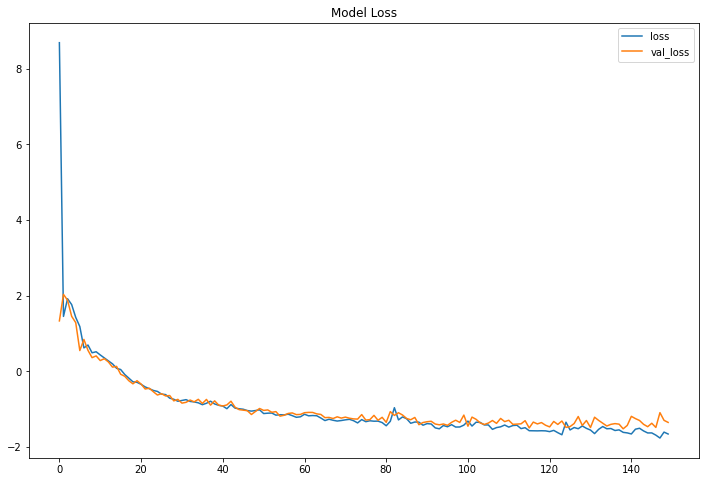

100%|██████████| 20/20 [00:12<00:00,  1.66it/s]

rmse: 0.0559227280318737
r2: 0.6316718178242018
For LSTM uncertainty model, 1.0 are in 99% confidence interval



c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_predict['predict'] = y_mean_transfrom
c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_predict['predict_low'] = lower_transfrom
c:\Users\MYCOM\IDB\Git\IDB_Workspace\RNN\uncertainty_rnn.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

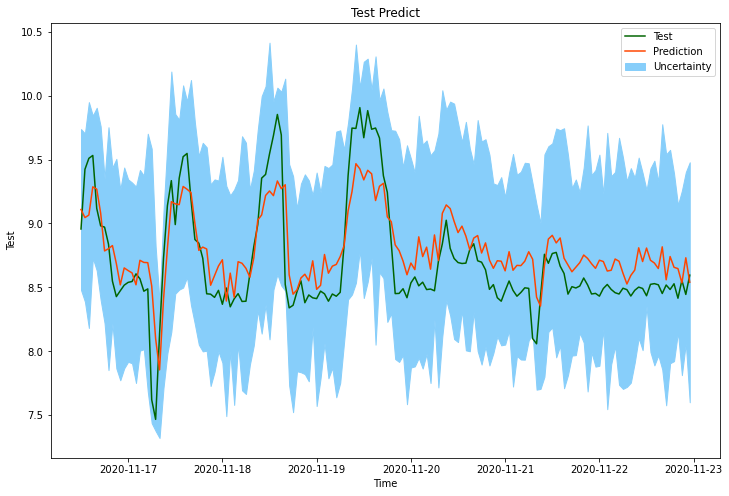

In [4]:
model3 = current.Transfomer_LSTM(key_dim = 64, num_heads=2, ff_dim=128, num_blocks=1)
model3 = current.fit(model=model3, epochs = 150, batch_size = 256, show_loss = True)
TransformerLSTM_predict = current.predict_ci(model=model3, n_sample = 20, ci=2.58, show= True)

In [8]:
TransformerLSTM_predict

,전류평균,T상전류,S상전류,R상전류,predict,predict_low,predict_up
2020-11-16 12:00:00,8.703472,8.540104,8.630729,8.939584,9.109669,8.479961,9.739377
2020-11-16 13:00:00,9.150521,8.970312,9.075521,9.406250,9.046196,8.387774,9.704618
2020-11-16 14:00:00,9.232986,9.036458,9.155209,9.507292,9.066124,8.181979,9.950268
2020-11-16 15:00:00,9.254687,9.060416,9.192187,9.510938,9.287073,8.729471,9.844676
2020-11-16 16:00:00,8.857986,8.650000,8.813541,9.110416,9.269103,8.632013,9.906193
...,...,...,...,...,...,...,...
2020-11-22 19:00:00,8.293056,8.018229,8.085938,8.775000,8.656995,7.922506,9.391483
2020-11-22 20:00:00,8.184722,7.910937,7.982292,8.661979,8.646863,8.149196,9.144530
2020-11-22 21:00:00,8.318750,8.028125,8.123959,8.806250,8.534753,7.812836,9.256670
2020-11-22 22:00:00,8.213195,7.933854,8.010417,8.695312,8.731523,8.061176,9.401870


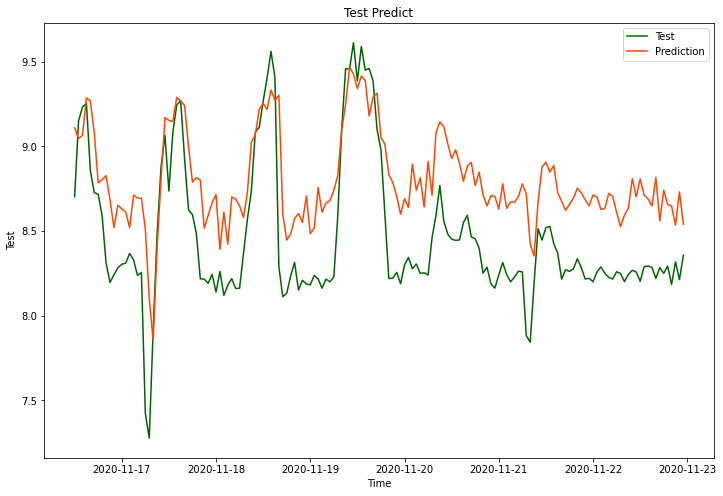

In [11]:
import matplotlib.pyplot as plt

tx = TransformerLSTM_predict.index
plt.figure(figsize=(12,8))
plt.plot(tx, TransformerLSTM_predict['전류평균'],'darkgreen')
plt.plot(tx, TransformerLSTM_predict['predict'], 'orangered')

plt.xlabel('Time')
plt.ylabel('Test')
plt.legend(['Test','Prediction',],loc='upper right')
plt.title('Test Predict')
plt.show() 